In [ ]:
import tensorflow
print(tensorflow.__version__)

2.12.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
dataset_dir = "/content/drive/MyDrive/BrainTumors/Training"
image_size = 256
batch_size = 32
epochs = 50

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size = (image_size,image_size),
    batch_size = batch_size
)

Found 3160 files belonging to 4 classes.


In [ ]:
class_names = data.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
len(data) # 3160/32

99

In [ ]:
for image_batch, labels_batch in data.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 2 3 1 3 0 1 0 3 0 2 1 1 0 2 0 1 3 0 2 0 1 1 2 2 0 2 1 1 2 0]


As shown above, each element in the dataset is a tuple. The first element consists of a batch of 32 image elements, while the second element comprises a batch of 32 class label elements

### Visualizing some of the images

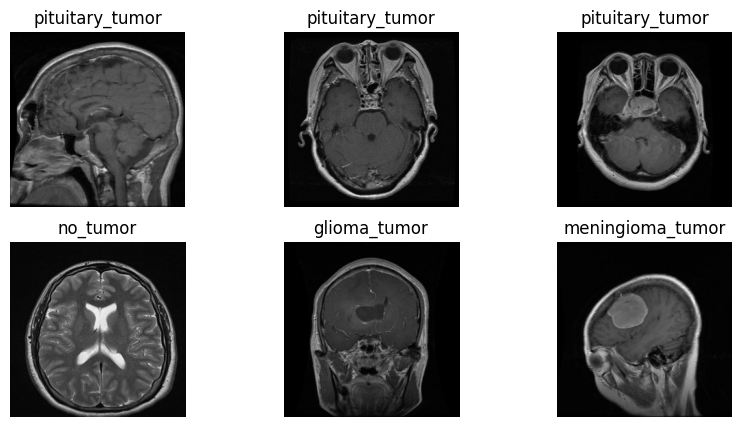

In [ ]:
plt.figure(figsize=(10, 5))
for image_batch, labels_batch in data.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Dividing Data into train,valid,test = 80:10:10




1.   Training: The dataset used during the training phase to optimize the model's parameters and improve its performance.
2.   Validation: The dataset used to assess the model's performance during training, providing an estimate of how well it generalizes to new, unseen data.
3.  Test: The dataset used to evaluate the final performance of the trained model after completing the training process. This dataset serves as an independent measure of the model's accuracy and generalization ability.

In [ ]:
train_size = 0.8
len(data)*train_size

79.2

In [ ]:
train_ds = data.take(79)
len(train_ds)

79

In [ ]:
test_ds = data.skip(79)
len(test_ds)

20

In [ ]:
val_size=0.1
len(data)*val_size

9.9

In [ ]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [ ]:
test_ds = test_ds.skip(9)
len(test_ds)

11

In [ ]:
def split_data(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = split_data(data)

In [ ]:
print("Length Of Train DataSet :- ",len(train_ds))
print("Length Of Validation DataSet :- ",len(val_ds))
print("Length Of Test DataSet :- ",len(test_ds))

Length Of Train DataSet :-  79
Length Of Validation DataSet :-  9
Length Of Test DataSet :-  11


### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model

##### Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])


##### Data Augmentation

In [ ]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [ ]:
train_ds = train_ds.map(lambda x, y: (data_aug(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds) ##remains same

79

##### Model - CNN

In [ ]:
n_classes = 4
channels = 3
input_shape = (batch_size, image_size, image_size, channels)


model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
79/79 [==============================] - 23s 282ms/step - loss: 1.1033 - accuracy: 0.5202 - val_loss: 1.0217 - val_accuracy: 0.6250
Epoch 2/50
79/79 [==============================] - 24s 302ms/step - loss: 1.0119 - accuracy: 0.5667 - val_loss: 0.9396 - val_accuracy: 0.6146
Epoch 3/50
79/79 [==============================] - 24s 304ms/step - loss: 0.9247 - accuracy: 0.6194 - val_loss: 0.9179 - val_accuracy: 0.6458
Epoch 4/50
79/79 [==============================] - 22s 281ms/step - loss: 0.8792 - accuracy: 0.6361 - val_loss: 0.8530 - val_accuracy: 0.6597
Epoch 5/50
79/79 [==============================] - 23s 296ms/step - loss: 0.8047 - accuracy: 0.6778 - val_loss: 0.7652 - val_accuracy: 0.6840
Epoch 6/50
79/79 [==============================] - 23s 297ms/step - loss: 0.7518 - accuracy: 0.6956 - val_loss: 0.7623 - val_accuracy: 0.6944
Epoch 7/50
79/79 [==============================] - 23s 290ms/step - loss: 0.7306 - accuracy: 0.7060 - val_loss: 0.6902 - val_accuracy: 0.7361

In [ ]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 13s 26ms/step - loss: 0.1835 - accuracy: 0.9331


In [ ]:
scores # a list containing loss and accuracy value

[0.1834639310836792, 0.9331395626068115]

##### Plotting the Accuracy and Loss Curves

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 79}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['loss'][:5] # loss for first 5 epochs

[1.103255033493042,
 1.0118660926818848,
 0.9247182607650757,
 0.879226565361023,
 0.8046679496765137]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

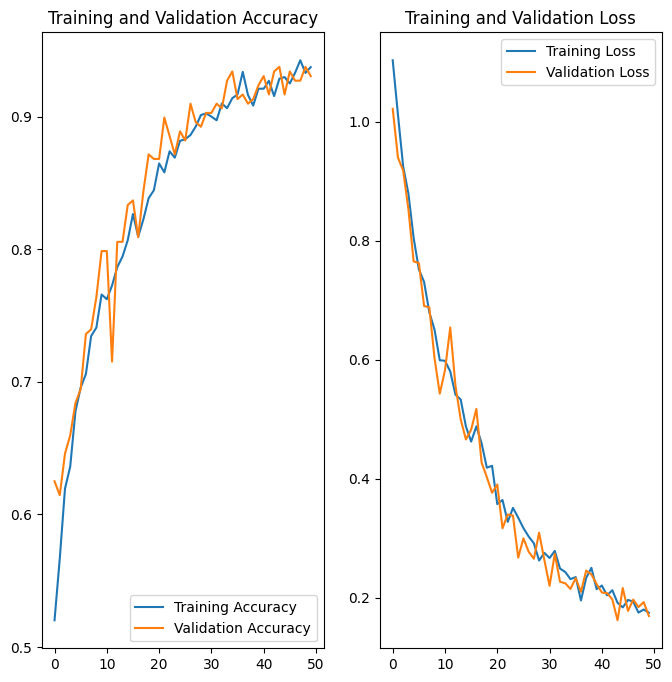

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Prediction

In [ ]:
import numpy as np

Actual label: glioma_tumor
1/1 [==============================] - 0s 157ms/step
Predicted label: glioma_tumor


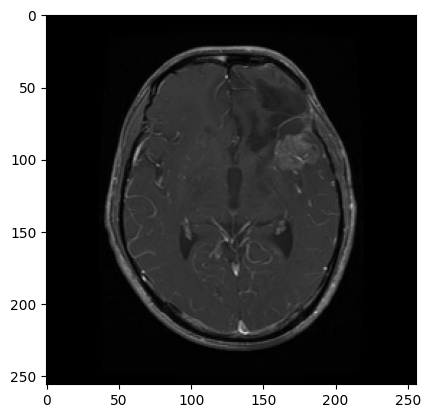

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    img = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()

    plt.imshow(img)
    print("Actual label:",class_names[label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


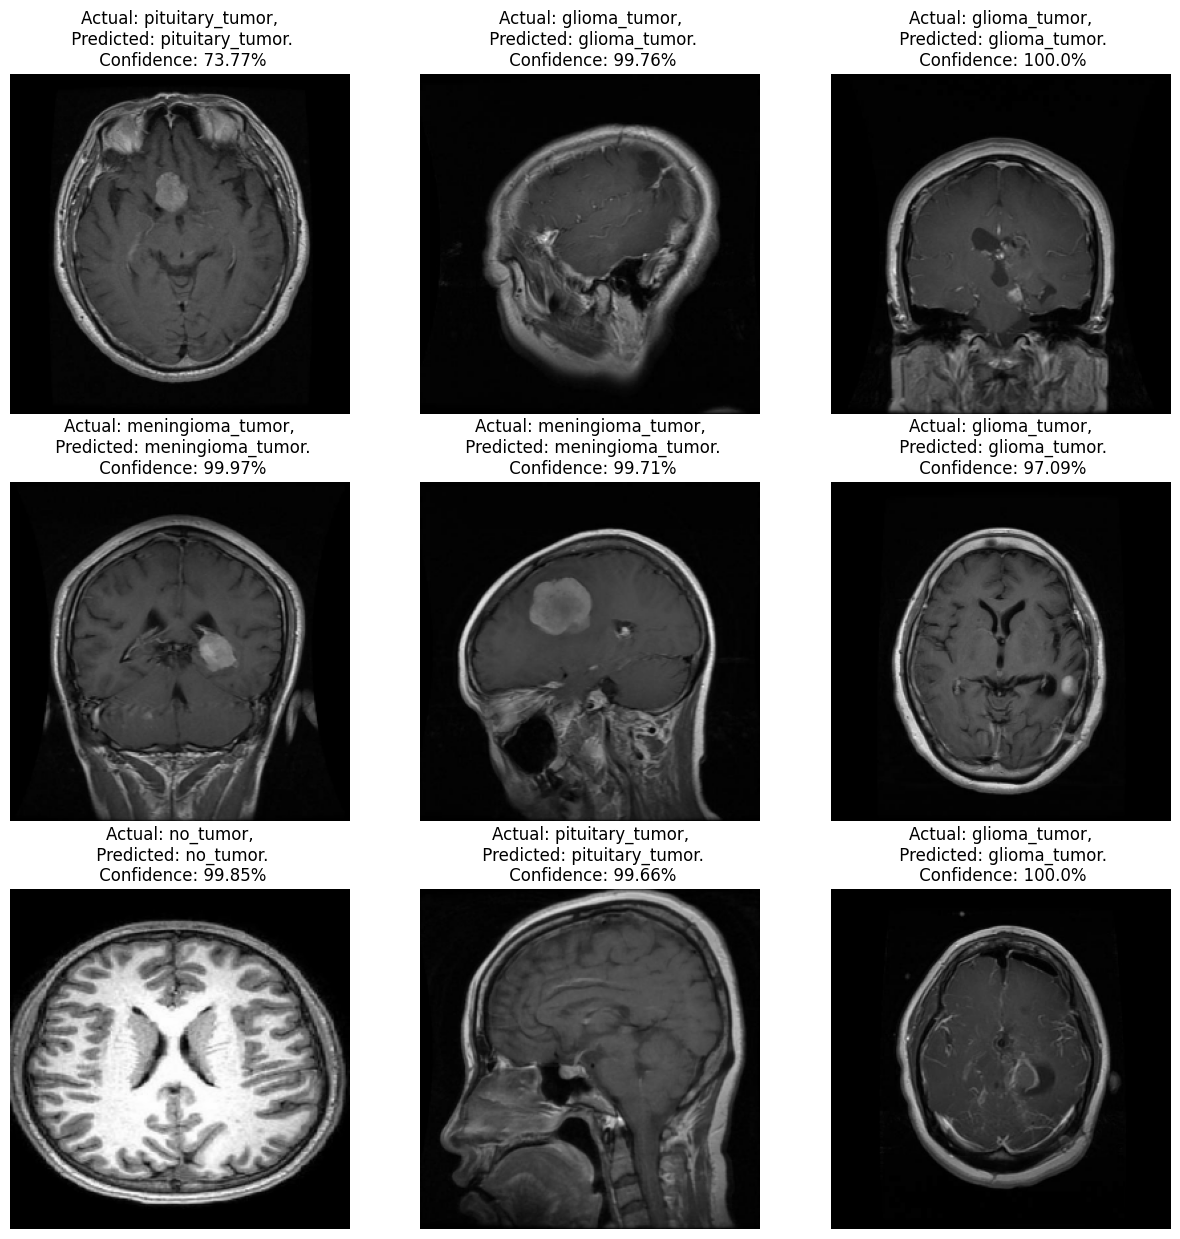

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save("model_cnn.h5")

In [ ]:
mkdir models

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/models") + [0]])+1
model.save(f"../{model_version}")

In [ ]:
def scale(image):
    image = tf.cast(image ,tf.float32)
    image /= 255.0
    return image

In [ ]:
# import streamlit as st
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
import cv2
import io

In [ ]:
m1 = tf.keras.models.load_model("/content/model_cnn.h5")
image1 = Image.open("/content/image(1).jpg")
image = cv2.cvtColor(np.array(image1), cv2.COLOR_RGB2BGR)
image = cv2.resize(image,(256,256))
image = tf.reshape(image, [1, 256, 256,3])
prediction = m1.predict(image)

1/1 [==============================] - 0s 102ms/step


In [ ]:
prediction[0]

array([4.9268422e-03, 9.9506348e-01, 9.7384946e-06, 7.9174854e-11],
      dtype=float32)

In [ ]:
np.argmax(prediction[0])

1